# Reinforcement Learning from Feedback Loop

In [1]:
!pip install matplotlib seaborn scikit-learn jupyterlab

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached scikit_learn-1.7.0-cp310-cp310-win_amd64.whl.metadata (14 kB)
  Using cached scipy-1.15.3-cp310-cp310-win_amd64.whl.metadata (60 kB)
  Using cached joblib-1.5.1-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached scikit_learn-1.7.0-cp310-cp310-win_amd64.whl (10.7 MB)
Using cached joblib-1.5.1-py3-none-any.whl (307 kB)
Using cached scipy-1.15.3-cp310-cp310-win_amd64.whl (41.3 MB)
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)

   -------- ------------------------------- 1/5 [scipy]
   -------- ------------------------------- 1/5 [scipy]
   -------- ------------------------------- 1/5 [scipy]
   -------- ------------------------------- 1/5 [scipy]
   -------- ------------------------------- 1/5 [scipy]
   -------- ------------------------------- 1/5 [scipy]
   -------- ------------

In [2]:
!pip install wandb datasets transformers tqdm trl

### Import dependencies

In [47]:
import random
import wandb
import time
#from tqdm import tqdm
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
from random import choices
import matplotlib.pyplot as plt

tqdm.pandas()

from datasets import load_dataset

from transformers import AutoTokenizer, pipeline

from trl import PPOTrainer, PPOConfig, create_reference_model, AutoModelForSeq2SeqLMWithValueHead
import os
import torch

import os


wandb.login()

device = "cuda" if torch.cuda.is_available() else "cpu"

device

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


'cuda'

# The Reward Pipeline

In [29]:
sentiment_pipeline = pipeline('text-classification', 'cardiffnlp/twitter-roberta-base-sentiment')

def get_neutral_scores(texts):
    scores = []
    # function_to_apply='none' returns logits which can be negative which is great for RL rewards
    results = sentiment_pipeline(texts, function_to_apply='none', top_k=None)
    for result in results:
        for label in result:
            if label['label'] == 'LABEL_1':  # logit for neutral class
                scores.append(label['score'])
    return scores

get_neutral_scores(['hello', 'I love you!', 'I hate you'])

[0.8519183397293091, -0.7468029260635376, -0.5696874856948853]

In [30]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("textattack/roberta-base-CoLA")
model = AutoModelForSequenceClassification.from_pretrained("textattack/roberta-base-CoLA")

cola_pipeline = pipeline('text-classification', model=model, tokenizer=tokenizer)

def get_cola_scores(texts):
    scores = []
    # note function_to_apply='none' gives me logits which can be negative (what we want)
    results = cola_pipeline(texts, function_to_apply='none', top_k=None)
    for result in results:
        for label in result:
            if label['label'] == 'LABEL_1':  # good grammar:
                scores.append(label['score'])
    return scores


Some weights of the model checkpoint at textattack/roberta-base-CoLA were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [31]:
test = """German police arrest 29-year-old man suspected of plotting truck attack on ice rink in Berlin,
killing 12 people, Reuters-German police say: 'It's a shame to have been arrested,'
a German police spokesman said in a statement."""

print(get_cola_scores([test]))
print(get_neutral_scores([test]))

[-0.38008734583854675]
[0.31116122007369995]


In [32]:
MODEL_NAME = "google/flan-t5-small"

# RL Configuration

In [33]:
config = PPOConfig(
    model_name=MODEL_NAME,
    batch_size=8,
    mini_batch_size=2,
    learning_rate=2e-5,
    remove_unused_columns=False,
    log_with="wandb",
    gradient_accumulation_steps=4,
)

np.random.seed(42)

In [34]:
flan_t5_model = AutoModelForSeq2SeqLMWithValueHead.from_pretrained(
    config.model_name
)  # going to be updated

flan_t5_model_ref = create_reference_model(flan_t5_model)  # is never updated (reference model)
flan_t5_tokenizer = AutoTokenizer.from_pretrained(config.model_name)


In [35]:
from datasets import load_dataset

dataset = load_dataset("argilla/news-summary")

In [36]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'prediction', 'prediction_agent', 'annotation', 'annotation_agent', 'id', 'metadata', 'status', 'event_timestamp', 'metrics'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['text', 'prediction', 'prediction_agent', 'annotation', 'annotation_agent', 'id', 'metadata', 'status', 'event_timestamp', 'metrics'],
        num_rows: 20417
    })
})

In [37]:
dataset['train'][0]

{'text': 'PHNOM PENH (Reuters) - Sweden said on Tuesday it was stopping new aid for Cambodia, except in education and research, and would no longer support a reform programme after the main opposition party was outlawed by the Supreme Court at the government s request. The announcement marked the first concrete action by a European Union country in protest at a political crackdown in which veteran Prime Minister Hun Sen s main rival has also been arrested and civil rights groups and independent media attacked. The United States cut election funding and said it would take more punitive steps after last week s ban on the Cambodia National Rescue Party (CNRP). The European Union has also threatened action. Sweden s embassy in Phnom Penh said the country was reviewing its engagement with Cambodia.   We will not initiate any new government-to-government development cooperation agreements, except in the areas of education and research,  it said in a statement. As a consequence, it would be u

In [38]:

# Preprocessing function
def preprocess(batch):
    # 'texts' should be a list of text entries within each batch
    texts = batch['text']  # assuming the key for your texts in your dataset is 'text'

    # Tokenize the texts (appending 'summarize: ' before each)
    tokenized_inputs = flan_t5_tokenizer(
        ['summarize: ' + t for t in texts],
        truncation=True,
        padding=True,
        return_tensors="pt"
    )

      # Remove padding
    input_ids_list = []
    attention_mask_list = []

    for idx, input_ids in enumerate(tokenized_inputs['input_ids']):
        actual_length = tokenized_inputs['attention_mask'][idx].sum()  # Count number of non-padding tokens
        input_ids_list.append(input_ids[:actual_length])
        attention_mask_list.append(tokenized_inputs['attention_mask'][idx, :actual_length])

    batch['input_ids'] = input_ids_list
    batch['attention_mask'] = attention_mask_list

    return batch

dataset['train'] = dataset['train'].map(
    preprocess,
    batched=True,
    batch_size=256,
    remove_columns=set(dataset['train'].column_names) - {'text',}
)

In [39]:
dataset.set_format("pytorch")

dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'input_ids', 'attention_mask'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['text', 'prediction', 'prediction_agent', 'annotation', 'annotation_agent', 'id', 'metadata', 'status', 'event_timestamp', 'metrics'],
        num_rows: 20417
    })
})

In [40]:
def collator(data):
    return dict((key, [d[key] for d in data]) for key in data[0])

# Load our reference FLAN-T5 Model

In [41]:
generation_kwargs = {
    "min_length": 64,  # forcing some behavior I want
    "num_beams": 5,  # lookahead parameter
    "no_repeat_ngram_size": 3,  # cannot say the same three n-grams in a row twice
    "do_sample": True,  # giving the LLM freedom to experiment
    "pad_token_id": flan_t5_tokenizer.pad_token_id,  # technically not needed in this example, but is if doing PPO in larger batches
    "max_length": 256,
    "eos_token_id": flan_t5_tokenizer.eos_token_id,
}


In [42]:
ppo_trainer = PPOTrainer(
    config, flan_t5_model,
    flan_t5_model_ref, flan_t5_tokenizer, dataset['train'],
    data_collator=collator
)

### Our RLF Loop


In [18]:
from tqdm.auto import tqdm

for epoch in tqdm(range(2)):
    for batch in tqdm(ppo_trainer.dataloader):
        game_data = dict()
        #### prepend the summarize token
        game_data["query"] = ['summarize: ' + b for b in batch["text"]]

        #### get response from flan-t5
        input_tensors = [_.squeeze() for _ in batch["input_ids"]]
        response_tensors = []
        for query in input_tensors:
            response = ppo_trainer.generate(query.squeeze(), **generation_kwargs)
            response_tensors.append(response.squeeze())

        game_data["response"] = [flan_t5_tokenizer.decode(r.squeeze(), skip_special_tokens=False) for r in response_tensors]

        #### reward system
        game_data["clean_response"] = [flan_t5_tokenizer.decode(r.squeeze(), skip_special_tokens=True) for r in response_tensors]
        game_data['cola_scores'] = get_cola_scores(game_data["clean_response"])
        game_data['neutral_scores'] = get_neutral_scores(game_data["clean_response"])
        # rewards = game_data['neutral_scores']
        transposed_lists = zip(game_data['cola_scores'], game_data['neutral_scores'])
        # Calculate the averages for each index
        rewards = [1 * values[0] +  0.5 * values[1] for values in transposed_lists]
        rewards = [torch.tensor([_]) for _ in rewards]
        # print(rewards)  # just to inspect :)

        #### Run PPO training
        stats = ppo_trainer.step(input_tensors, response_tensors, rewards)

        stats['env/reward'] = np.mean([r.cpu().numpy() for r in rewards])
        ppo_trainer.log_stats(stats, game_data, rewards)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# save locally
flan_t5_model.save_pretrained("t5-align")
flan_t5_tokenizer.save_pretrained("t5-align")

In [ ]:
# Pushing to Huggingface

username, repo_name = 'profoz', 't5-aligned-summaries'

# Push model and tokenizer to Hugging Face Hub
flan_t5_model.push_to_hub(f"{username}/{repo_name}")
flan_t5_tokenizer.push_to_hub(f"{username}/{repo_name}")

In [43]:
old_summarizer = pipeline("text2text-generation", MODEL_NAME, device=0)
new_summarizer = pipeline("text2text-generation", 'profoz/t5-aligned-summaries', device=0)
#new_summarizer = pipeline("text2text-generation", "t5-align", device=0)

In [44]:
import random

# Assuming load_dataset function loads the dataset
dataset = load_dataset("argilla/news-summary")['test']['text']

# Filter dataset for entries with less than 400 characters
filtered_dataset = [text for text in dataset if len(text) < 450 and len(text) > 200]

filtered_dataset = random.sample(filtered_dataset, len(filtered_dataset))

In [48]:
import matplotlib.pyplot as plt

old_summaries, new_summaries = [], []
# Lists to store scores
summary_list, sentiment_scores_old, sentiment_scores_new, cola_scores_old, cola_scores_new = [], [], [], [], []

for i, article in enumerate(tqdm(filtered_dataset)):
    # Old model
    results_old = old_summarizer(f"summarize: {article}", **generation_kwargs)
    summary_text_old = results_old[0]['generated_text']
    old_summaries.append(summary_text_old)

    # New model
    results_new = new_summarizer(f"summarize: {article}", **generation_kwargs)
    summary_text_new = results_new[0]['generated_text']
    new_summaries.append(summary_text_new)

    # if summary_text_new.endswith('.') and '...' not in summary_text_new:
    # print(f"Generated Summary {i+1} [NEW]: {summary_text_new}")

    # Old scores
    sentiment_score_old = get_neutral_scores([summary_text_old])
    sentiment_scores_old.extend(sentiment_score_old)
    cola_score_old = get_cola_scores([summary_text_old])
    cola_scores_old.extend(cola_score_old)

    # New scores
    sentiment_score_new = get_neutral_scores([summary_text_new])
    sentiment_scores_new.extend(sentiment_score_new)
    # print(f"Neutral Rewards for Summary {i+1} [NEW]: {sentiment_score_new}")

    cola_score_new = get_cola_scores([summary_text_new])
    cola_scores_new.extend(cola_score_new)
    # print(f"Cola Rewards for Summary {i+1} [NEW]: {cola_score_new}")

  0%|          | 0/1409 [00:00<?, ?it/s]

Average Neutral Reward [OLD]: 1.3033660625929187
Average Cola Reward [OLD]: 0.7960860020807575
Average Neutral Reward [NEW]: 1.3188748414779572
Average Cola Reward [NEW]: 0.8650108039882457


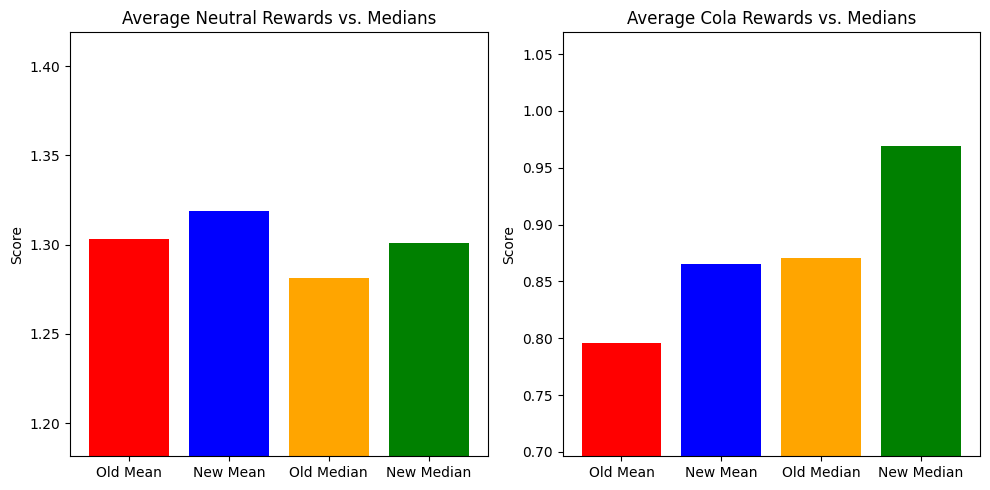

In [49]:

# Calculate averages
average_sentiment_score_old = sum(sentiment_scores_old) / len(sentiment_scores_old)
average_cola_score_old = sum(cola_scores_old) / len(cola_scores_old)
average_sentiment_score_new = sum(sentiment_scores_new) / len(sentiment_scores_new)
average_cola_score_new = sum(cola_scores_new) / len(cola_scores_new)

median_sentiment_score_old = np.median(sentiment_scores_old)
median_cola_score_old = np.median(cola_scores_old)
median_sentiment_score_new = np.median(sentiment_scores_new)
median_cola_score_new = np.median(cola_scores_new)

std_sentiment_score_old = np.std(sentiment_scores_old)
std_cola_score_old = np.std(cola_scores_old)
std_sentiment_score_new = np.std(sentiment_scores_new)
std_cola_score_new = np.std(cola_scores_new)

print(f'Average Neutral Reward [OLD]: {average_sentiment_score_old}')
print(f'Average Cola Reward [OLD]: {average_cola_score_old}')
print(f'Average Neutral Reward [NEW]: {average_sentiment_score_new}')
print(f'Average Cola Reward [NEW]: {average_cola_score_new}')
# print('---------------------------')

# Graph the differences
plt.figure(figsize=(10, 5))

# Sentiment scores
plt.subplot(1, 2, 1)
plt.bar(["Old Mean", "New Mean", "Old Median", "New Median"],
        [average_sentiment_score_old, average_sentiment_score_new, median_sentiment_score_old, median_sentiment_score_new],
        color=['red', 'blue', 'orange', 'green'])
plt.title("Average Neutral Rewards vs. Medians")
plt.ylabel("Score")
plt.ylim(min(average_sentiment_score_old, average_sentiment_score_new, median_sentiment_score_old, median_sentiment_score_new) - 0.1,
         max(average_sentiment_score_old, average_sentiment_score_new, median_sentiment_score_old, median_sentiment_score_new) + 0.1)

# Cola scores
plt.subplot(1, 2, 2)
plt.bar(["Old Mean", "New Mean", "Old Median", "New Median"],
        [average_cola_score_old, average_cola_score_new, median_cola_score_old, median_cola_score_new],
        color=['red', 'blue', 'orange', 'green'])
plt.title("Average Cola Rewards vs. Medians")
plt.ylabel("Score")
plt.ylim(min(average_cola_score_old, average_cola_score_new, median_cola_score_old, median_cola_score_new) - 0.1,
         max(average_cola_score_old, average_cola_score_new, median_cola_score_old, median_cola_score_new) + 0.1)

plt.tight_layout()
plt.show()